In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# organizing X data 

In [2]:
data = np.load('face_images.npz')['face_images']

In [3]:
print(data.shape)
x = np.moveaxis(data, -1, 0)
print(x.shape)

(96, 96, 7049)
(7049, 96, 96)


# organizing y data

In [4]:
ys = pd.read_csv('facial_keypoints.csv')

In [5]:
ys_cols = ys.columns
print(type(ys_cols))
ys_cols = ys.columns.tolist()
print(type(ys_cols))
print(ys_cols)

<class 'pandas.core.indexes.base.Index'>
<class 'list'>
['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']


## preprocessing

In [6]:
print(ys.isnull().sum())

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [8]:
y_pro = np.nonzero(ys.left_eye_center_x.notna() & ys.right_eye_center_x.notna() & ys.nose_tip_x.notna() & ys.mouth_center_bottom_lip_x.notna())[0]

In [9]:
print(type(y_pro))
print(y_pro.shape)

<class 'numpy.ndarray'>
(7000,)


In [10]:
m = y_pro.shape[0]
size = x.shape[1]
print(m, size)

7000 96


# X and Y 

In [11]:
X = np.zeros((m, size, size, 1))
Y = np.zeros((m, 8))

In [12]:
X[:,:,:,0] = x[y_pro, :, :] / 255.0

In [13]:
Y[:, 0] = ys.left_eye_center_x[y_pro] / size
Y[:, 1] = ys.left_eye_center_y[y_pro] / size
Y[:, 2] = ys.right_eye_center_x[y_pro] / size
Y[:, 3] = ys.right_eye_center_y[y_pro] / size
Y[:, 4] = ys.nose_tip_x[y_pro] / size
Y[:, 5] = ys.nose_tip_y[y_pro] / size
Y[:, 6] = ys.mouth_center_bottom_lip_x[y_pro] / size
Y[:, 7] = ys.mouth_center_bottom_lip_y[y_pro] / size

In [14]:
print(m)

7000


# Displaying data

In [21]:
n = 0

nrows = 4
ncols = 4

random_imgs = np.random.choice(Y.shape[0], nrows*ncols)
print(random_imgs)

[5685 1837 3043 1619 6885 4947  810 3598 4768 1489 2318 1568 4137 6801
 1608 5111]


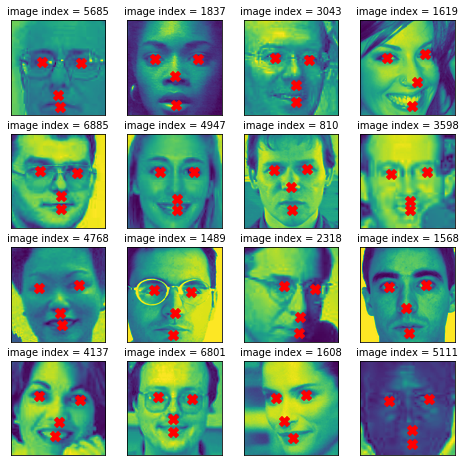

In [22]:
fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = True, figsize = [ncols * 2, nrows * 2])

for row in range(nrows):
    for col in range(ncols):
        ax[row, col].imshow(X[random_imgs[n],:,:,0])
        ax[row, col].scatter(Y[random_imgs[n],0::2] * size , Y[random_imgs[n], 1::2] * size, marker = 'X', c = 'r', s = 100)
        ax[row, col].set_xticks(())
        ax[row, col].set_yticks(())
        ax[row, col].set_title('image index = %d' %(random_imgs[n]), fontsize = 10)
        n += 1
        

# split the dataset

In [24]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5600, 96, 96, 1) (1400, 96, 96, 1) (5600, 8) (1400, 8)


# creating model and training

In [27]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model 

Using TensorFlow backend.


In [32]:
def facemodel(input_shape):
    X_input = Input(input_shape)
    
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((2, 2), name = 'max_pool')(X)
    X = Dropout(0.25)(X)
    
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((2, 2), name = 'max_pool1')(X)
    X = Dropout(0.25)(X)
    
    X = Flatten()(X)
    X = Dense(256, activation = 'tanh', name = 'fc')(X)
    X = Dropout(0.5)(X)
    
    X = Dense(8, activation = 'sigmoid', name = 'fc1')(X)
    
    model = Model(inputs = X_input, outputs = X, name = 'facemodel')
    
    return model

In [33]:
faceModel = facemodel((96, 96, 1))

In [35]:
faceModel.compile(optimizer = "adam", loss = 'mean_squared_error', metrics = ['accuracy'])

In [36]:
faceModel.fit(x = X_train, y = y_train, epochs = 3, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
5600/5600 [==============================] - 101s 18ms/step - loss: 0.0581 - acc: 0.0805
Epoch 2/3
5600/5600 [==============================] - 97s 17ms/step - loss: 0.0254 - acc: 0.6721
Epoch 3/3
5600/5600 [==============================] - 93s 17ms/step - loss: 0.0086 - acc: 0.8377


In [37]:
faceModel.fit(x = X_train, y = y_train, epochs = 3, batch_size = 32)

Epoch 1/3
5600/5600 [==============================] - 89s 16ms/step - loss: 0.0029 - acc: 0.9746
Epoch 2/3
5600/5600 [==============================] - 92s 16ms/step - loss: 0.0021 - acc: 0.9921
Epoch 3/3
5600/5600 [==============================] - 90s 16ms/step - loss: 0.0020 - acc: 0.9923


In [38]:
preds = faceModel.evaluate(x = X_test, y = y_test)

print()
print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

1400/1400 [==============================] - 14s 10ms/step

Loss = 0.0018785889100815568
Test Accuracy = 0.9928571425165449


Text(0.5, 0.98, 'x: Manual; +: CNN')

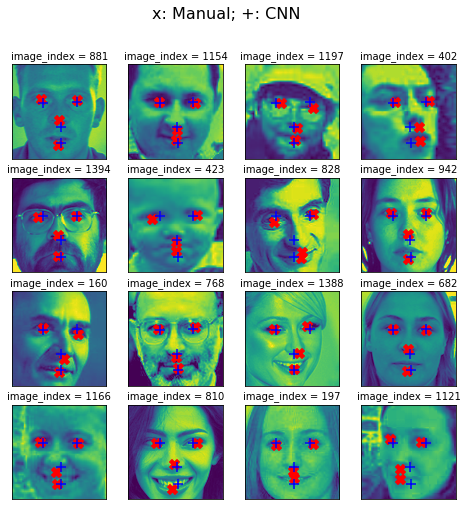

In [40]:
y_train_pred = faceModel.predict(X_train)
y_test_pred = faceModel.predict(X_test)

n = 0
nrows = 4
ncols = 4

rand_imgs = np.random.choice(y_test.shape[0], nrows * ncols)

fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = True, figsize = [ncols * 2, nrows * 2])

for row in range(nrows):
    for col in range(ncols):
        ax[row, col].imshow(X_test[rand_imgs[n],:,:,0])
        ax[row, col].scatter(y_test[rand_imgs[n],0::2] * size, y_test[rand_imgs[n], 1::2] * size, marker = 'X', c = 'r', s = 100)
        ax[row, col].scatter(y_test_pred[rand_imgs[n],0::2] * size, y_test_pred[rand_imgs[n], 1::2] * size, marker = '+', c = 'b', s = 100)
        ax[row, col].set_xticks(())
        ax[row, col].set_yticks(())
        ax[row, col].set_title('image_index = %d' %(rand_imgs[n]), fontsize = 10)
        n += 1
        
plt.suptitle('x: Manual; +: CNN', fontsize = 16)

## train accuracy: 0.9923
## test accuracy: 0.9928

In [41]:
faceModel.save_weights('weights.h5', overwrite = True)

In [2]:
import os

In [43]:
open('architecture.json', 'w').write(faceModel.to_json())

5453

In [45]:
from keras.models import model_from_json

In [46]:
newFaceModel = model_from_json(open('architecture.json').read())
newFaceModel.load_weights('weights.h5')